# EVAC-2 Assessment
## Exam Number: Y3868718
This notebook contains all code and explanations of said code. Code is separated into blocks, organised and split by purpose of code. 

The method used for this assessment to evolve agents throughout gameplay was a neural network, where weights of said neural network are evolved generation by generation. Further detail can be found at the relevant code sections within this report.

The time taken to run this entire notebook on Google Colab is approximately 16 minutes, with the time taken to train a single population being approximately 38 seconds.

The below import cell is required by Google Colab to install the `DEAP` library required to run the genetic algorithm implemented in this notebook.

In [1]:
!pip install deap

All imports required for this notebook can be found in the below cell.

In [2]:
import numpy as np
from deap import base
from deap import tools
import random
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import math

## Agent Representation
As each agent is required to be part of a group, groups were defined as an integer with representation as follows:
* `0` - Saints
* `1` - Buddies
* `2` - Fight Club
* `3` - Vandals

An agent was decided to be represented using the class `Player`, this class could then be used to keep track of all important agent attributes:
* `wealth` - The total wealth of the agent.
* `startingGroup` - The initial group assignment of the agent, reassigned each generation start. This is randomly allocated when the agent is first created.
* `group` - The current group assignment of the agent.
* `gameCount` - The number of games played by the agent.
* `weights` - List of floats used in the neural network to make a decision on which group to join. Evolved by the evolutionary algorithm.
* `fitness` - Current fitness of the agent. 

The game can be played by calling the `getPayoff()` method with the opponent as the required parameter. This is called for each of the two agents chosen in a single game as each agent assumes the role of opponent to the other. Representing each group as an integer allows for very simple calculation of payoffs, with a lookup table implemented for each agent as follows: `[[4,0,4,0],[6,4,6,1],[4,0,1,0],[6,1,6,0]]`. This lookup table stores the payoffs for each group interaction with each group, for a total of 16 different possible interactions. 

The evolutionary aspect of the player class is called with `evaluate()`, with the required parameters of the current game opponent along with an instance of the neural network class. This method loads the agent weights into the neural network, calculates the group that the agent should be assigned to (this is the agent deciding if it should move group) and then the agent fitness is assigned as the agent wealth divided by the game count. This fitness was chosen to allow for a fair comparison between agents regardless of how many games they were randomly chosen to play.

The `reset()` method is called to setup an agent ready for a new generation. This resets the group to the agents starting group, along with setting the agent wealth, fitness, and game counter to 0.

In [3]:
class Player():
  '''
  stores all data required by one agent
  '''
  def __init__(self, IND_SIZE):
    '''
    initialises an agent ready to play a game 

    args:
      int IND_SIZE - size of neural network, therefore number of weights 
                     required
    '''
    self.wealth = 0
    # starting group randomly selected
    self.startingGroup = random.randint(0,3)
    # current group agent is a member of 
    self.group = self.startingGroup
    self.gameCount = 0
    # weights to be used in the neural network, randomly initially assigned
    self.weights = tools.initRepeat(list, toolbox.attr_float, IND_SIZE)
    self.fitness = 0
  
  def evaluate(self,opponent,network):
    '''
    calculate agent group decision

    args:
      Player opponent - player instance of the opponent this agent is playing 
                        against
      NeuralNetwork - network - neural network instance to apply weights to and
                      make group decision
    '''
    # set agent weights in network
    network.setWeightsLinear(self.weights)
    # get group output from neural network
    output = network.feedForward([self.wealth, self.group, 
                                  opponent.wealth, opponent.group])
    self.group = np.argmax(output, axis=0)

  def addPayoff(self, opponent):
    '''
    calculate agent payoff, add to wealth, increment game counter, set fitness

    args:
      Player opponent - player instance of the opponent this agent is playing
                        against
    '''
    # payoff lookup table
    payoffs = [[4,0,4,0],[6,4,6,1],[4,0,1,0],[6,1,6,0]]
    # add value from relevant value in lookup table
    self.wealth += payoffs[self.group][opponent.group]
    self.gameCount += 1
    # set fitness as agent average payoff
    self.fitness = self.wealth / self.gameCount

  def reset(self):
    '''
    reset agent ready for the next generation
    '''
    self.wealth = 0
    self.gameCount = 0
    self.group = self.startingGroup
    self.fitness = 0

## Agent Evolution Environment

### Neural Network
The neural network used by all agents in the system is a single hidden layer network with 4 input nodes, 8 hidden nodes and 4 output nodes. These 4 output nodes represent the decision of which group to join, and a group is selected using a `softmax` function. The input nodes of this neural network are the agents own group, the agents own wealth, the opponents group and the opponents wealth. These inputs were settled on after experimentation with other inputs such as the number of games the agent had played, or the current game number. These additional inputs did not improve performance and were removed to reduce chance of overfitting.

A bias of 1 was added to the input layer to improve performance.

In [4]:
# layer node count
numInputNodes = 4
numHiddenNodes = 8
numOutputNodes = 4

# number of weights required by neural network
IND_SIZE = ((numInputNodes+1) * numHiddenNodes)+(numHiddenNodes * numOutputNodes)

class NeuralNetwork(object):
  '''
  neural network for decision on which group agent should join
  '''
  def __init__(self, numInput, numHidden, numOutput):
    '''
    initialises neural network ready for use

    args:
      int numInput - number of input nodes
      int numHidden - number of hidden nodes in single hidden node layer
      int numOutput - number of output nodes (1 per group)
    '''
    self.numInput = numInput + 1
    self.numHidden = numHidden
    self.numOutput = numOutput

    # generate some basic weights for the network
    self.wh = np.random.randn(self.numHidden, self.numInput) 
    self.wo = np.random.randn(self.numOutput, self.numHidden)

    # rectified linear unit to be used in hidden layer
    self.ReLU = lambda x : max(0,x)

  def softmax(self, x):
    '''
    used to normalise output layer

    args:
      list (float) x - output layer of neural network
    return:
      softmax of x
    '''
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

  def feedForward(self, inputs):
    '''
    run inputs through neural network

    args:
      list inputs - neural network inputs
    return:
      softmax output of network
    '''
    # add data to input layer
    inputsBias = inputs[:]
    inputsBias.insert(len(inputs), 1)

    # feed input layer to hidden layer
    h1 = np.dot(self.wh, inputsBias)
    h1 = [self.ReLU(x) for x in h1]

    # feed hidden layer to output layer
    output = np.dot(self.wo, h1)
    return self.softmax(output)

  def setWeightsLinear(self, Wgenome):
    '''
    set given weights for neural network

    args:
      list (float) Wgenome - list of weights evolved by an agent
    '''
    numWeights_IH = self.numHidden * (self.numInput)
    # set hidden layer weights
    self.wh = np.array(Wgenome[:numWeights_IH])
    self.wh = self.wh.reshape((self.numHidden, self.numInput))
    # set output layer weights
    self.wo = np.array(Wgenome[numWeights_IH:])
    self.wo = self.wo.reshape((self.numOutput, self.numHidden))

### Running the Simulation
The game simulation is defined as: for a set number of games, two agents are selected at random from a population to play against each other. Payoffs are calculated and each agent is then given the opportunity to change groups. 

This is implemented within the method `playGameAndEvolve` using the constant `NGAMES` to define the number of games played, and `POP` to specify the population size. The two agents are selected using the code `random.sample(range(POP),2)`, which selects two distinct population indexes, these agents then calculate their respective payoffs (and fitness) using `addPayoff`, and calculate their decision on if they should migrate groups using `evaluate`. Details of these methods are found in the Agent Representation part of this code.

`playBasicGame` is an additional method that can be used to run the game without allowing agents to swap their group assignments, this will be used to evaluate the behaviour developed through adaption.

`POP` and `NGAMES` were selected with the computational power of Google Colab in mind to provide a large population without taking too long to execute.

In [5]:
# set game number and population
NGAMES = 5000
POP = 500

def playGameAndEvolve(pop, network):
  '''
  play NGAMES number of games, allowing agents to make decisions on when to 
  change groups using the neural network

  args:
    list (Player) pop - population of agents
    NeuralNetwork network - neural network to use to evaluate
  return:
    population
  '''
  for r in range(NGAMES):
    # randomly select two distinct agents
    selection = random.sample(range(POP),2)
    # calculate each agent payoff
    pop[selection[0]].addPayoff(pop[selection[1]])
    pop[selection[1]].addPayoff(pop[selection[0]])
    # give each agent the opportunity to change groups
    pop[selection[0]].evaluate(pop[selection[1]],network)
    pop[selection[1]].evaluate(pop[selection[0]],network)
  return pop

def playBasicGame(pop):
  '''
  play NGAMES number of games, do not use the neural network or allow agents to 
  change groups

  args:
    list (Player) pop - population of agents
  return:
    population
  '''
  for r in range(NGAMES):
    # randomly select two distinct agents
    selection = random.sample(range(POP),2)
    # calculate each agent payoff
    pop[selection[0]].addPayoff(pop[selection[1]])
    pop[selection[1]].addPayoff(pop[selection[0]])
  return pop

## Agent Adaptation Procedure (Training through Evolution)
Below are some helpful methods to keep track of population performance through evolution. `countGroups()` gets number of agents in each group, while `fitnessStats()` gets the mean, minimum and maximum fitness values for the whole population.

In [6]:
def countGroups(pop):
  '''
  get the total number of agents in each group

  args:
    list (Player) pop - population of agents
  return:
    int list of counts of each group
  '''
  groupTotals=[0,0,0,0]
  for person in pop:
    groupTotals[person.group] += 1
  return groupTotals

def fitnessStats(pop):
  '''
  calculate fitness statistics of the population

  args:
    list (Player) pop - population of agents
  return:
    dictionary of mean, max, min of agent fitness
  '''
  fitnessSum = 0
  fitnessMax = 0 
  fitnessMin = -1
  for person in pop:
    # set highest fitness
    if(person.fitness > fitnessMax):
      fitnessMax = person.fitness
    # set lowest fitness
    if(person.fitness < fitnessMin or fitnessMin == -1):
      fitnessMin = person.fitness
    # sum fitness to be divided for mean
    fitnessSum += person.fitness
  return { "mean": fitnessSum/len(pop), "max":fitnessMax, "min":fitnessMin }

### Evolutionary training method
To evolve each agents neural network weightings, the python module `DEAP` has been used. `DEAP` allows for easy crossover, mutation and selection of the population:
* Crossover - Defined as `mate` within the `DEAP` toolbox, implemented using the `cxOnePoint` method. Probability of crossover for each individual is defined by constant `CXPB` set to `0.1`.
* Mutation - Defined as `mutate` within the `DEAP` toolbox, implemented using the `mutGaussian` method with the parameters `mu=0.0, sigma=0.5, indpb=INDPB`. Probability of an individual being subject to mutation is defined by constant `MUTPB` set to `0.5`, and probability of each chromosome within a selected individual (neural network weight in this implementation) being mutated is defined by constant `INDPB` set to `0.1`. 
* Selection - Defined as `select` within the `DEAP` toolbox, implemented using the `selTournament` method with a tournament size of 3.
* Generations - Number of generations is defined by constant `NGEN` set to `50`.

Once these toolbox commands are setup, a population of constant size `POP` (set to 500) is generated using `DEAP` where an individual in that population is an instance of the previously discussed `player` class. An instance of the neural network is also initialized to be used by the agents in the population. The game is then played with this initial population and fitness information is output. Generational evolution then begins.

For each generation, tournament selection is used to select a new population of agents based on the fitness of the previous generation. This new population is then subject to crossover and mutation for each agents neural network weights. During mutation an individual also has a chance to mutate its starting group to another randomly selected group. This has the same probability of being mutated as each weight in an agent does. All agents in the population are then reset to their starting values (wealth, group, fitness and number of games played), the game then is played with this new population and fitness information for this new population is output. The next generation then begins.

Using this method, a population uses multi-agent evolution to evolve as each game pits agents against each other. The data passed to the next generation of agents consists of the neural network weights of an agent along with the initial group assignment of the agent. This generational evolution code output can be seen in the output of this cell, showing for each generation the average and max fitness of the population, along with the group distribution of the population after all games are played.

In [7]:
# set evolution probabilities 
INDPB = 0.1
CXPB  = 0.1
MUTPB = 0.5
# set number of generations
NGEN  = 50

# setup DEAP toolbox of methods used to evolve
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", Player, IND_SIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=INDPB)
toolbox.register("pop", tools.initRepeat, list, toolbox.individual)

def evolvePopulation(verbose=True):
  groupMembership = [[],[],[],[]]
  generationFitness = []
  # initialise neural network
  network = NeuralNetwork(numInputNodes, numHiddenNodes, numOutputNodes)

  # setup population
  pop = toolbox.pop(n=POP)
  if (verbose):
    print("-- Generation 1 --")
  # initial play game, allowing agents to swap groups using neural network
  pop[:] = playGameAndEvolve(pop, network)
  # get results of game
  popFitness = fitnessStats(pop)
  generationFitness.append(popFitness["mean"])
  currentGroups = countGroups(pop)
  for i in range(len(currentGroups)):
    groupMembership[i].append(currentGroups[i])
  # output generation data
  if (verbose): 
    print("Fitness avg: "+str(popFitness["mean"]))
    print("Fitness max: "+str(popFitness["max"]))
    print("Group count: "+str(currentGroups))

  # run for all generations
  for g in range(2,NGEN+1):
    if (verbose):
      print("-- Generation %i --" % g)
    # use tournament selection to select offspring
    offspring = toolbox.select(pop, len(pop))
    # clone selected offspring
    offspring = list(map(toolbox.clone, offspring))

    # perform crossover for all combinations of offspring (mating)
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      # only mate if under crossover probability threshold
      if random.random() < CXPB:
        toolbox.mate(child1.weights, child2.weights)

    # mutate an agent
    for mutant in offspring:
      # only mutate if under mutation probability threshold
      if random.random() < MUTPB:
        toolbox.mutate(mutant.weights)
        # only change group if under independent probability threshold 
        if (random.random() < INDPB):
          mutant.startingGroup = random.randint(0,3)

    # reset all agents in the population
    for person in offspring:
      person.reset()
    
    # play game, allowing agents to swap groups using neural network
    pop[:] = playGameAndEvolve(offspring, network)
    # get results of game
    popFitness = fitnessStats(pop)
    generationFitness.append(popFitness["mean"])
    currentGroups = countGroups(pop)
    for i in range(len(currentGroups)):
      groupMembership[i].append(currentGroups[i])
    # output generation data
    if (verbose): 
      print("Fitness avg: "+str(popFitness["mean"]))
      print("Fitness max: "+str(popFitness["max"]))
      print("Group count: "+str(currentGroups))
  return pop, groupMembership, generationFitness

pop, groupsByGeneration, fitnessByGeneration = evolvePopulation()

-- Generation 1 --
Fitness avg: 2.7052530566250863
Fitness max: 5.304347826086956
Group count: [130, 120, 128, 122]
-- Generation 2 --
Fitness avg: 2.348364780171771
Fitness max: 5.166666666666667
Group count: [76, 207, 51, 166]
-- Generation 3 --
Fitness avg: 2.8205196778481905
Fitness max: 4.538461538461538
Group count: [44, 348, 19, 89]
-- Generation 4 --
Fitness avg: 3.438327174199863
Fitness max: 4.5
Group count: [31, 431, 12, 26]
-- Generation 5 --
Fitness avg: 3.6220237323556312
Fitness max: 4.555555555555555
Group count: [16, 457, 15, 12]
-- Generation 6 --
Fitness avg: 3.6389396225072512
Fitness max: 4.631578947368421
Group count: [15, 458, 13, 14]
-- Generation 7 --
Fitness avg: 3.7603808207043943
Fitness max: 4.444444444444445
Group count: [8, 476, 8, 8]
-- Generation 8 --
Fitness avg: 3.7170115820060308
Fitness max: 4.428571428571429
Group count: [13, 462, 12, 13]
-- Generation 9 --
Fitness avg: 3.7286439010332613
Fitness max: 4.545454545454546
Group count: [9, 463, 12, 16]

The below cell output is two graphs, the first graph is of of the group counts at the end of each generation, which clearly shows a trend of all agents quickly learning an optimal behaviour of joining the buddies society. The second graph is of the average fitness of all agents in the population at the end of each generation. This graph shows a trend of the average fitness converging towards 4.

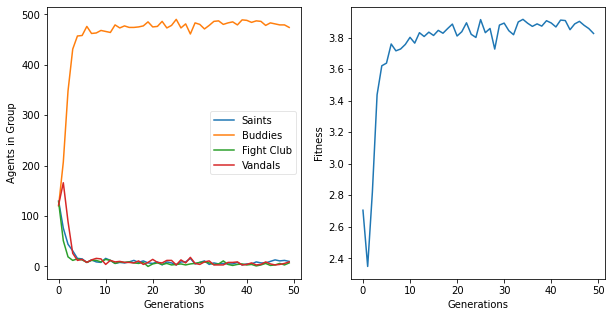

In [8]:
# setup labels
labels = ["Saints", "Buddies", "Fight Club", "Vandals"]
# setup subplots to display two graphs
figure, axis = plt.subplots(1,2,figsize=(10,5))

# plot all groups 
for group in groupsByGeneration:
  axis[0].plot(group)
# label groups
axis[0].legend(labels, loc='best', fancybox=True, framealpha=0.5)
# label axes
axis[0].set_xlabel('Generations')
axis[0].set_ylabel('Agents in Group')
axis[1].set_xlabel('Generations')
axis[1].set_ylabel('Fitness')
# plot average fitness
axis[1].plot(fitnessByGeneration)
plt.show()

## Evaluation
The evolved population needs to be statistically compared to a population of agents that have not been evolved or allowed to change groups. As evolution has an element of randomness to it (along with the game itself being inherently random), both populations will be ran 30 times, with the average fitness of the population recorded. These 30 average fitness values for the evolved population will be compared as a group to 30 average fitness values obtained by the 30 runs of non-evolved population that is not allowed to change groups.

First, these runs are performed by the below cell:

In [9]:
avgBaseFitnesses=[]
print("Begin basic run : ", end="")
for i in range(1,31):
  # setup population
  pop = toolbox.pop(n=POP)
  # play game
  pop = playBasicGame(pop)
  # save average fitness
  avgBaseFitnesses.append(fitnessStats(pop)["mean"])
  # add dot to loading bar
  print(".", end="")
print(" Basic run complete")

avgEvolvedFitnesses=[]
print("Begin evolve run: ", end="")
for i in range(1,31):
  # evolve population
  pop, groupsByGeneration, fitnessByGeneration = evolvePopulation(verbose=False)
  # save average fitness of last generation
  avgEvolvedFitnesses.append(fitnessByGeneration[-1])
  # add dot to loading bar
  print(".", end="")
print(" Evolve run complete")

# output both average lists to visually check
print("Basic fitness averages:")
print(avgBaseFitnesses)
print("Evolved fitness averages:")
print(avgEvolvedFitnesses)

Begin basic run : .............................. Basic run complete
Begin evolve run: .............................. Evolve run complete
Basic fitness averages:
[2.797915667803283, 2.6426266546061714, 2.750092595339091, 2.6470030186296163, 2.661634289638753, 2.6594813544230163, 2.858940523381521, 2.559263864699405, 2.6612539276859692, 2.6478183317875126, 2.663880893609176, 2.60724530251553, 2.6826649967285476, 2.7505463968978225, 2.8088278692361626, 2.6707851963746645, 2.8000166757525453, 2.5718791409305166, 2.7810540152385377, 2.610800870503941, 2.74881038092658, 2.6859870145723246, 2.6474846992199885, 2.5942603315076145, 2.580090895580863, 2.655857384328612, 2.7628075302213793, 2.6787671471210666, 2.6851683516925977, 2.6953975005667776]
Evolved fitness averages:
[3.843483392006978, 3.931488963852618, 3.8649967135033467, 3.95490252152545, 3.891345072467807, 3.9168712299854533, 3.92621889164957, 3.9419959309926287, 3.87520759812952, 3.9393814664343267, 3.9529434689781713, 3.94926725137

To know which statistical test should be used to compare the two average populations, we first need to find out if the above collected data is normally distributed. This can be checked by simply creating a boxplot for each population of average fitness values and examining the output. These boxplots are generated by the below cell, and from the output we can clearly deduce that both populations are normally distributed.

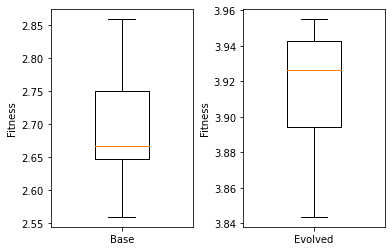

In [10]:
# setup subplots to display two graphs
figure, axis = plt.subplots(1,2)
# appropriately space graphs
figure.subplots_adjust(wspace=0.35)
# plot base fitness box
axis[0].boxplot([avgBaseFitnesses])
# appropriate space box in graph
axis[0].set_xlim(0.8, 1.2)
# set labels
axis[0].set_xticklabels(["Base"])
axis[0].set_ylabel('Fitness')
# plot evolved fitness box
axis[1].boxplot([avgEvolvedFitnesses])
# appropriate space box in graph
axis[1].set_xlim(0.8, 1.2)
# set labels
axis[1].set_xticklabels(["Evolved"]) 
axis[1].set_ylabel('Fitness')
plt.show()

As the data has been found to be normally distributed, an unpaired t-test is the appropriate statistical method to follow. We now need to check if the data is of equal variance, which cannot be can be visually approximated using the above generated boxplots as they are not on the same axis. We will instead check variance using the numpy library on each population of average fitnesses. The ratio between these two variances can be used to determine if the populations are of equal variance.

As shown by the output of the below cell, the ratio of variances between these two populations is `5.9`. As `5.9 > 4`, we can safely assume that these populations of average fitness are not of equal variance and therefore a Welch t-test should be performed to statistically compare the two. 

In [11]:
# calculate variances
baseVariance = np.var(avgBaseFitnesses)
evolvedVariance = np.var(avgEvolvedFitnesses)

# output variances
print("Base variance   :   " + str(baseVariance))
print("Evolve variance :   " + str(evolvedVariance))
print("Ratio           :   " + str(baseVariance/evolvedVariance))

Base variance   :   0.005609316421658773
Evolve variance :   0.0009494663995414356
Ratio           :   5.907861957377226


Running a Welch t-test is easy to do using the python module `scipy`. The below cell computes the `p` value for the statistical significance of the two populations. This p value is calculated as `7.5x10e-45`, therefore as `p < 0.05` we can safely say that the evolutionary algorithm used to evolve the population of agents is statistically significant.

The effect size of this statistical significance was computed using Cohen's D and is output in the below cell as well. Cohen's D states that any value greater than `0.8` is a large effect size. The two populations of average fitnesses tested have no overlap of distribution so the output of Cohen's D is `21.5`, allowing the evolutionary algorithm to be classified as having a very large effect size.

In [12]:
# calculate Welch t-test and output
stat, p = stats.ttest_ind(avgBaseFitnesses, avgEvolvedFitnesses, equal_var=False)
print("p value    : "+str(p))

# calculate cohen's D and output
def cohensD(pop1,pop2):
  meanDiff = abs(np.mean(pop1)-np.mean(pop2))
  avgStd = math.sqrt((baseVariance+evolvedVariance)/2)
  return meanDiff / avgStd

print("Effect size: "+str(cohensD(avgBaseFitnesses, avgEvolvedFitnesses)))

p value    : 7.50716303607856e-45
Effect size: 21.5116833124566


## Conclusions
Through the statistical comparisions carried out in this notebook, the multi-agent evolutionary adaptation method created for this problem produces a population that is statistically significant from the original population. The population consistently trends to all agents in the population joining the `Buddies` society which makes logical sense as the strategy of `Buddies` allows for maximum wealth gain when playing within the group, while also being defensive of any outside groups that may decide to be selfish.

The fitness trend of average agent fitness converging to 4 is the best possible performance, as in a multi-agent evolutionary system, all agents should strive to the highest score possible. The best choice to benefit all agents is the choice with the highest total payoff, and the `4,4` both opponents cooperate strategy is the best total payoff for the population, so an average fitness converging to 4 shows that the ideal strategy is consistently found by the evolutionary algorithm. 